# Exploring different sequence models - Sarcasm

In [1]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-07-25 17:05:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  20.7MB/s    in 0.3s    

2020-07-25 17:05:39 (20.7 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [2]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [3]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

In [4]:
sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [9]:
training_sentences[:5], training_labels[:5]

(["former versace store clerk sues over secret 'black code' for minority shoppers",
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  "mom starting to fear son's web series closest thing she will have to grandchild",
  'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
  'j.k. rowling wishes snape happy birthday in the most magical way'],
 [0, 0, 1, 1, 0])

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index



In [17]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


# Single Layer LSTM

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [19]:

num_epochs = 50
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)


Epoch 1/50
625/625 [==============================] - 37s 60ms/step - loss: 0.4695 - accuracy: 0.7703 - val_loss: 0.3903 - val_accuracy: 0.8188
Epoch 2/50
625/625 [==============================] - 37s 59ms/step - loss: 0.3623 - accuracy: 0.8319 - val_loss: 0.3863 - val_accuracy: 0.8244
Epoch 3/50
625/625 [==============================] - 37s 59ms/step - loss: 0.3490 - accuracy: 0.8371 - val_loss: 0.3826 - val_accuracy: 0.8244
Epoch 4/50
625/625 [==============================] - 37s 60ms/step - loss: 0.3306 - accuracy: 0.8510 - val_loss: 0.3748 - val_accuracy: 0.8322
Epoch 5/50
625/625 [==============================] - 37s 60ms/step - loss: 0.3138 - accuracy: 0.8609 - val_loss: 0.3673 - val_accuracy: 0.8326
Epoch 6/50
625/625 [==============================] - 37s 59ms/step - loss: 0.3032 - accuracy: 0.8656 - val_loss: 0.3718 - val_accuracy: 0.8329
Epoch 7/50
625/625 [==============================] - 37s 58ms/step - loss: 0.2957 - accuracy: 0.8686 - val_loss: 0.3745 - val_accuracy:

In [20]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


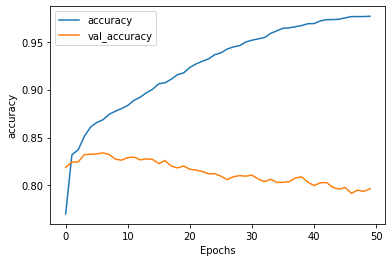

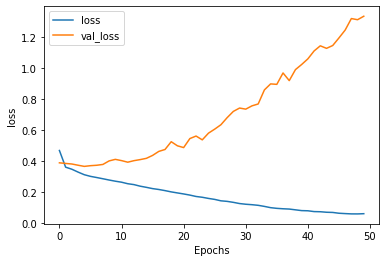

In [21]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# Multiple Layer GRU

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [23]:
num_epochs = 50

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)


Epoch 1/50
625/625 [==============================] - 4s 6ms/step - loss: 0.4702 - accuracy: 0.7624 - val_loss: 0.4068 - val_accuracy: 0.8152
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 0.3564 - accuracy: 0.8382 - val_loss: 0.3940 - val_accuracy: 0.8205
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 0.3187 - accuracy: 0.8592 - val_loss: 0.3964 - val_accuracy: 0.8226
Epoch 4/50
625/625 [==============================] - 4s 6ms/step - loss: 0.2829 - accuracy: 0.8779 - val_loss: 0.4080 - val_accuracy: 0.8199
Epoch 5/50
625/625 [==============================] - 4s 6ms/step - loss: 0.2482 - accuracy: 0.8947 - val_loss: 0.4300 - val_accuracy: 0.8188
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 0.2123 - accuracy: 0.9127 - val_loss: 0.4710 - val_accuracy: 0.8150
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 0.1784 - accuracy: 0.9295 - val_loss: 0.5227 - val_accuracy: 0.8109
Epoch 

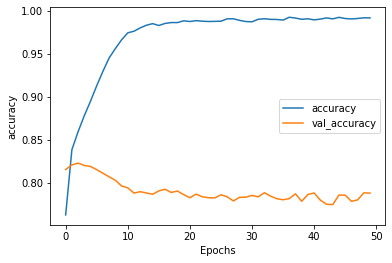

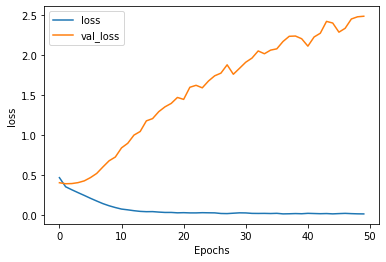

In [24]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')